In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from datetime import datetime as dt
import tensorflow as tf
#from pandas_datareader import data
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%reload_ext tensorboard

#tensorboard.__version__

In [2]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Usando feature-eng para crear un modelo exponencial de Covid-19

**Content**

Each row contains report from each region/location for each day
Each column represents the number of cases reported from each country/region


**Acknowledgements**

https://github.com/CSSEGISandData/COVID-19


In [ ]:
covid19_data = pd.read_csv('https://raw.githubusercontent.com/imdevskp/covid_19_jhu_data_web_scrap_and_cleaning/master/covid_19_clean_complete.csv')
covid19_data["Date"] = pd.to_datetime(covid19_data["Date"],infer_datetime_format = True)
iniciopandemia = covid19_data["Date"].min()

covid19_data["dias"]=covid19_data["Date"]-iniciopandemia
covid19_data.head(100)


In [ ]:
covid19_data.dtypes

In [ ]:
GT_confirmed = covid19_data[(covid19_data["Country/Region"] == 'Guatemala') & (covid19_data["Confirmed"] > 0)].copy()
plt.scatter(x = GT_confirmed["Date"],y="Confirmed")

In [ ]:
GT_confirmed["ln(confirmed)"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Date",y="ln(confirmed)")


In [ ]:
GT_confirmed.head(20)

In [ ]:
GT_confirmed_post24 = GT_confirmed[GT_confirmed.Date >= '2020-03-22']
GT_confirmed_post24.plot.scatter(x = "Date",y="ln(confirmed)")

In [ ]:
#import datetime as dt
#GT_confirmed['Date'] = pd.to_datetime(GT_confirmed['Date'])
#GT_confirmed['Date']=GT_confirmed['Date'].map(dt.datetime.toordinal)
#feature_cols = [tf.feature_column.numeric_column('Date') for "Date" in GT_confirmed]
#GT_confirmed.head()

codi19




In [ ]:
GT_confirmed.dtypes

#### PARTE 2: MODELO PARA CALIDAD DE VINOS
Se procede a cargar en datos la información contenida en el CSV.

In [22]:
datos= pd.read_csv("winequality-red.csv")
datos.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Ahora se cargan los datos en dataset independientes, para X y para Y

In [8]:
datosY = datos[['quality']]
datosX = datos[['volatile acidity', 'alcohol']]

datosX.head()

,volatile acidity,alcohol
0,0.70,9.4
1,0.88,9.8
2,0.76,9.8
3,0.28,9.8
4,0.70,9.4


Ahora se graficarán los datos para comprender mejor el dataset.

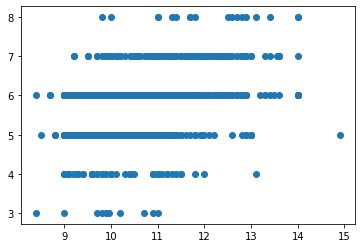

In [9]:
plt.scatter(datosX['alcohol'], datosY)

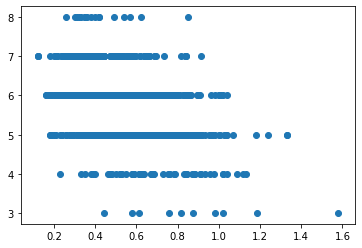

In [10]:
plt.scatter(datosX['volatile acidity'], datosY)

Ahora se generará la tabla que contiene **a**, **b**, **a^2**, **b^2** y **ab**

In [11]:
xEnt = datosX.copy()
yEnt = datosY.copy()
xEnt.columns=['a', 'b']
xEnt['ab'] = xEnt['a']*xEnt['b']
xEnt['a^2'] = xEnt['a']*xEnt['a']
xEnt['b^2'] = xEnt['b']*xEnt['b']
xEnt.insert(0,'',1)

pol = xEnt.shape[1]
xEnt.head()

,,a,b,ab,a^2,b^2
0,1,0.70,9.4,6.580,0.4900,88.36
1,1,0.88,9.8,8.624,0.7744,96.04
2,1,0.76,9.8,7.448,0.5776,96.04
3,1,0.28,9.8,2.744,0.0784,96.04
4,1,0.70,9.4,6.580,0.4900,88.36


A continuación, se procede a definir el grafo

In [12]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    xplace = tf.placeholder(tf.float32, shape = (None, pol), name = "X")
    yplace = tf.placeholder(tf.float32, shape = (None, 1), name = "Y")

    lr = tf.placeholder(tf.float32, name = "lr")

    W = tf.Variable(tf.zeros([pol, 1], tf.float32), name = "W")

    with tf.name_scope("Hipotesis"):
        Yhat = tf.matmul(xplace, W, name = "Diferencia_Y") 
        
    with tf.name_scope("Costo"):
        cost = tf.divide( tf.reduce_mean(tf.pow(Yhat-yplace, 2)), 2., name="fCosto")

    with tf.name_scope("Gradient_Descent"):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)
        costSummary = tf.summary.scalar(name='FuncionDeCosto', tensor = cost)
    init = tf.global_variables_initializer()

Ahora se hace una función que permita ejecutar la sesión a través de un procedimiento.

In [13]:
logs_dir = r"C:\Users\diego\StatisticalLearning\Practica2\practica2-StadisticalLearning\logs"

def entrenamiento(x, y, training_epochs, learning_rate,n):
    with tf.Session(graph = g) as sess: 
        writer = tf.summary.FileWriter(logs_dir, sess.graph)        
        sess.run(init) 
        print("USANDO UN LR DE ", learning_rate, ":")
        for epoch in range(training_epochs): 
            _, summary = sess.run([optimizer, costSummary], feed_dict = {xplace: xEnt, yplace: yEnt, lr : learning_rate})
            writer.add_summary(summary, epoch+1)
            if (epoch + 1) % n == 0: 
                c, weights = sess.run([cost, W], feed_dict = {xplace : x, yplace : y}) 
                print("Epoch:", (epoch + 1), "\t Grado_de_Polinomio=", pol,"\t Valor_Costo=", c, "\t Muestra_W=", weights[:3,0]) 
        writer.close()
        
        finalCost = sess.run(cost, feed_dict ={xplace: xEnt, yplace: yEnt}) 
        weights = sess.run(W)        
    return (weights)

A continuación se procede a entrenar el modelo lineal que se usará.

In [14]:
pesos = entrenamiento(xEnt, yEnt, 300, 0.0001, 30)

USANDO UN LR DE  0.0001 :
Epoch: 30 	 Grado_de_Polinomio= 6 	 Valor_Costo= 0.55953723 	 Muestra_W= [0.00091392 0.00043177 0.00718594]
Epoch: 60 	 Grado_de_Polinomio= 6 	 Valor_Costo= 0.5568993 	 Muestra_W= [0.00139531 0.00063713 0.00977986]
Epoch: 90 	 Grado_de_Polinomio= 6 	 Valor_Costo= 0.5542979 	 Muestra_W= [0.0018743  0.0008399  0.01236085]
Epoch: 120 	 Grado_de_Polinomio= 6 	 Valor_Costo= 0.5517324 	 Muestra_W= [0.0023509  0.00104013 0.01492902]
Epoch: 150 	 Grado_de_Polinomio= 6 	 Valor_Costo= 0.5492015 	 Muestra_W= [0.00282513 0.00123785 0.0174845 ]
Epoch: 180 	 Grado_de_Polinomio= 6 	 Valor_Costo= 0.5467047 	 Muestra_W= [0.00329702 0.00143309 0.02002738]
Epoch: 210 	 Grado_de_Polinomio= 6 	 Valor_Costo= 0.5442413 	 Muestra_W= [0.00376659 0.0016259  0.02255781]
Epoch: 240 	 Grado_de_Polinomio= 6 	 Valor_Costo= 0.5418105 	 Muestra_W= [0.00423386 0.0018163  0.02507587]
Epoch: 270 	 Grado_de_Polinomio= 6 	 Valor_Costo= 0.5394115 	 Muestra_W= [0.00469885 0.00200433 0.02758169]
Epoc

Ahora se generará una nueva tabla donde se trabaja el modelo cúbico

In [15]:
xEntTf = xEnt.copy()
xEntTf['ab^2'] = xEnt['a'] * xEnt['b^2']
xEntTf['ba^2'] = xEnt['b'] * xEnt['a^2']
xEntTf['a^3'] = xEnt['a'] ** 3
xEntTf['b^3'] = xEnt['b'] ** 3
pol = xEntTf.shape[1]

xEntTf.head()

,,a,b,ab,a^2,b^2,ab^2,ba^2,a^3,b^3
0,1,0.70,9.4,6.580,0.4900,88.36,61.8520,4.60600,0.343000,830.584
1,1,0.88,9.8,8.624,0.7744,96.04,84.5152,7.58912,0.681472,941.192
2,1,0.76,9.8,7.448,0.5776,96.04,72.9904,5.66048,0.438976,941.192
3,1,0.28,9.8,2.744,0.0784,96.04,26.8912,0.76832,0.021952,941.192
4,1,0.70,9.4,6.580,0.4900,88.36,61.8520,4.60600,0.343000,830.584


Ahora iniciamos tensorboard con los datos del log de trabajo

In [16]:
%tensorboard --logdir="C:\Users\diego\StatisticalLearning\Practica2\practica2-StadisticalLearning\logs" --port=6061

Reusing TensorBoard on port 6061 (pid 21716), started 0:12:31 ago. (Use '!kill 21716' to kill it.)

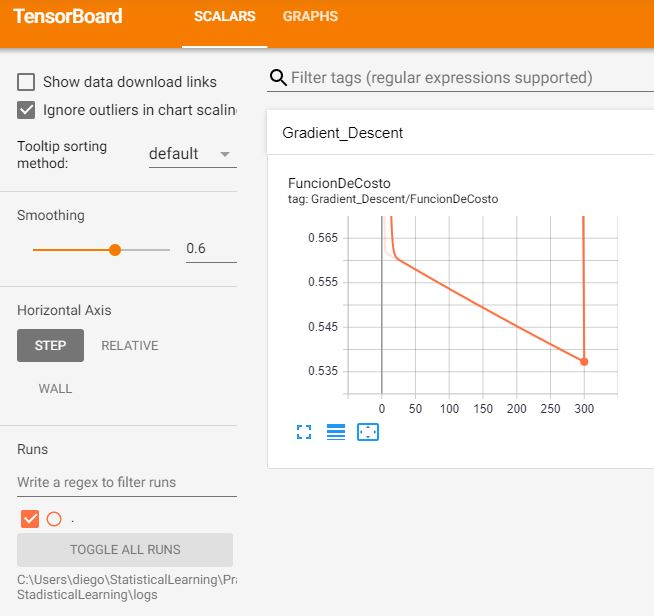

In [25]:
from IPython.display import Image
Image("grafico.jpg")

Ahora se procederá a predecir la calidad _quality_ del vino con valor entre 0 y 10 con base en las 11 variables de entrada definidas.

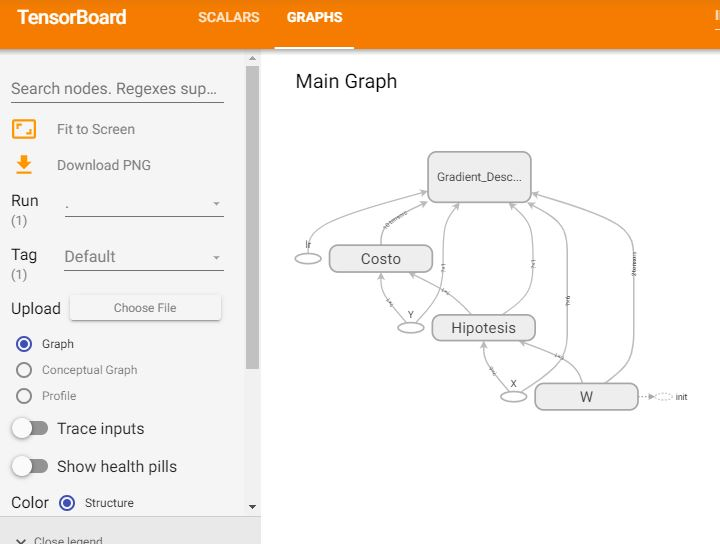

In [26]:
Image("grafos.jpg")

In [17]:
datos.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Se procede a generar un mapa de calor para entender mejor la correlación entre variables.

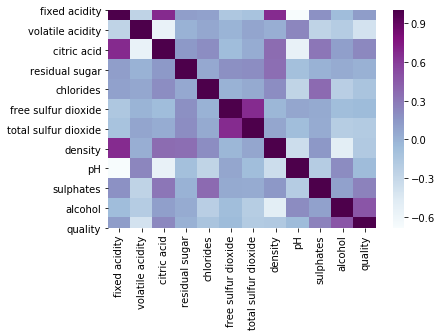

In [18]:
import seaborn as sns

correlacionMatematica = datos.corr()
sns.heatmap(correlacionMatematica,cmap="BuPu")

Con base en el mapa de calor observado anteriormente, podemos observar que la relación entre variables que tienen tonalidades más oscuras es mayor.

Aplicaremos ahora la función que nos permita entrenar los datos y predecir los datos.

In [19]:
x = datos[['quality']]
y = datos[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']]

entrenaX,pruebaX,entrenaY,pruebaY = train_test_split(x, y, test_size=0.1)

modelo = linear_model.LinearRegression()
modelo = modelo.fit(entrenaY, entrenaX)
datosPredecidos = modelo.predict(pruebaY)
datosPredecidos = np.round_(datosPredecidos)
print(datosPredecidos)

[[6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [5.]
 [4.]
 [5.]
 [6.]
 [6.]
 [6.]
 [6.]
 [5.]
 [5.]
 [5.]
 [5.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [6.]
 [5.]
 [5.]
 [7.]
 [6.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [6.]
 [5.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [5.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [5.]
 [5.]
 [5.]
 [6.]
 [6.]
 [6.]
 [6.]
 [5.]
 [5.]
 [5.]
 [6.]
 [5.]
 [5.]
 [5.]
 [5.]
 [6.]
 [6.]
 [6.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [6.]
 [7.]
 [6.]
 [6.]
 [6.]
 [7.]
 [6.]
 [5.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [6.]
 [6.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [6.]
 [5.]
 [5.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [5.]
 [5.]
 [5.]
 [6.]
 [5.]
 [6.]
 [7.]
 [6.]
 [6.]
 [5.]
 [5.]
 [7.]
 [7.]
 [6.]
 [5.]
 [6.]
 [5.]]


Ahora procedemos a mostrar el error entre datos y los datos predecidos.

In [20]:
print("El error es de:" ,mean_squared_error(pruebaX,datosPredecidos))

El error es de: 0.4125


Por lo tanto se recomienda usando el principio de la navaja de Ockham que sólo se usen las variables que tienen una mayor correlación, siendo estas _fixed acidity_ y _alcohol_ como variables en este modelo.